1. Download the data

In [1]:
import os
import tarfile
from urllib import request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  request.urlretrieve(housing_url, tgz_path)

  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [2]:
fetch_housing_data()

2. Load data with pandas

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Check how many different categories exist under this feature.
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


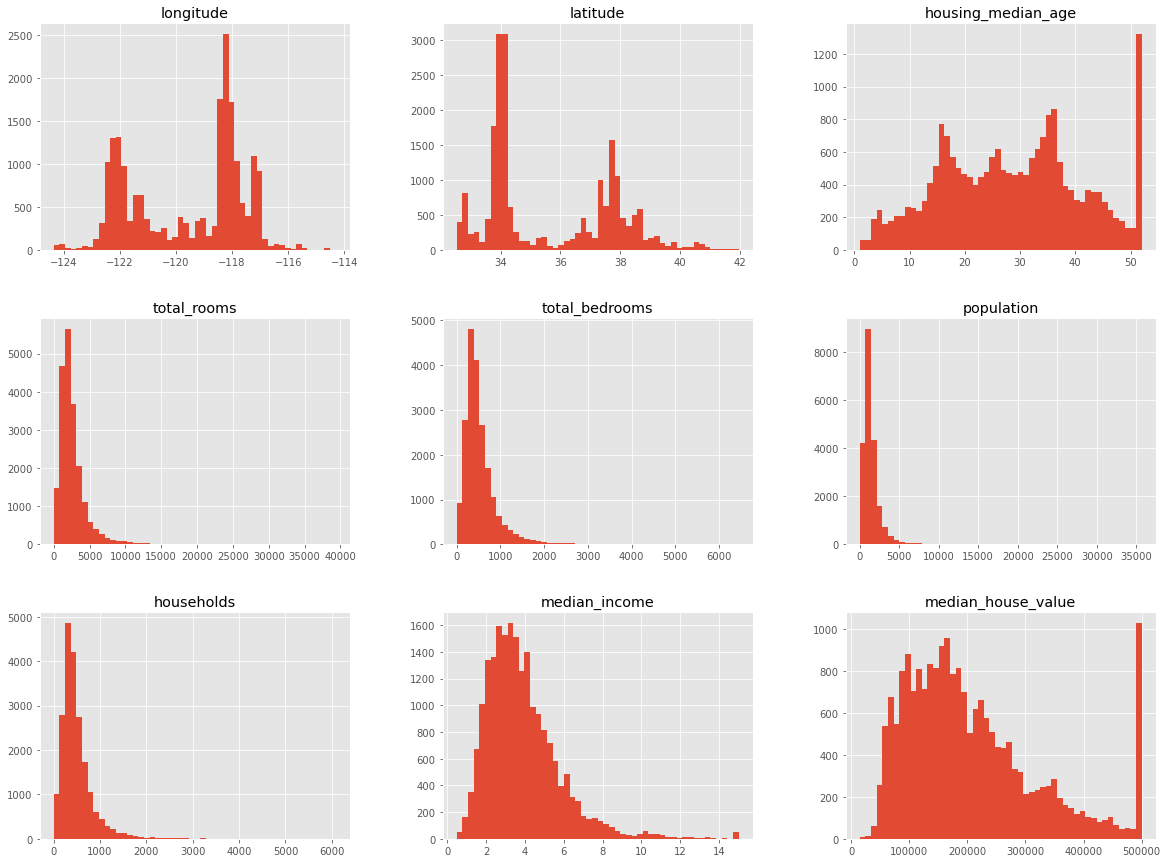

In [8]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

housing.hist(bins=50, figsize=(20,15))
plt.show()

3. Create test set

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

# np.random.seed(42) # Makes sure that each time the train and test sets are the same can use random_state arg instead

X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(16512, 4128)

4. Create categories (strata) of income

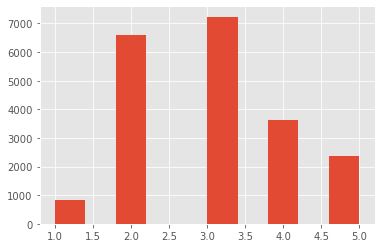

In [10]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5,])
housing["income_cat"].hist()
plt.show()

In [11]:
# Create Stratifie Split

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]
  

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [12]:
# Remove income_cat helper column
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [13]:
housing = strat_train_set.copy()

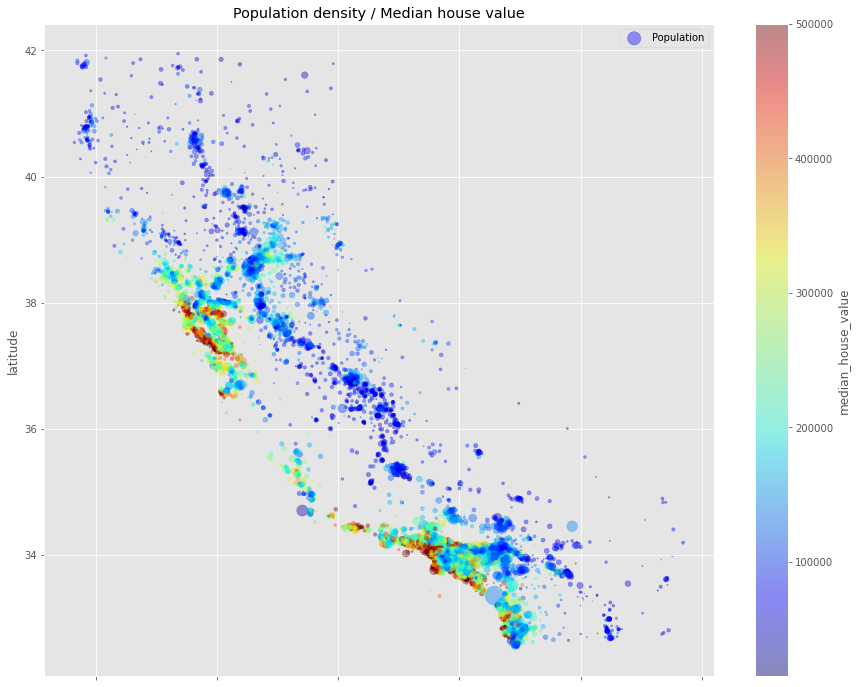

In [14]:
housing.plot(
  kind="scatter", x="longitude", y="latitude", figsize=(15, 12), 
  alpha=0.4, s=housing["population"]/100, label="Population", 
  c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
  title="Population density / Median house value"
  )
plt.legend()
plt.show()

In [15]:
# Calculating standard correlations coefficient (Pearson's r)

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

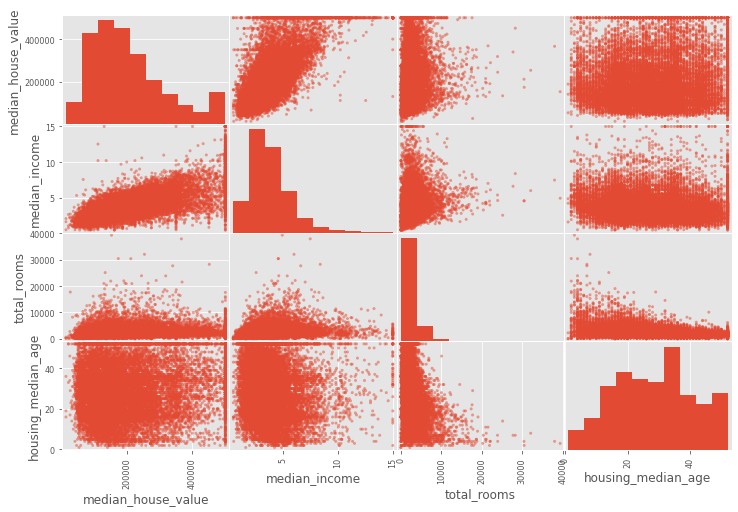

In [16]:
from pandas.plotting import scatter_matrix

attribiutes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attribiutes], figsize=(12, 8))
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

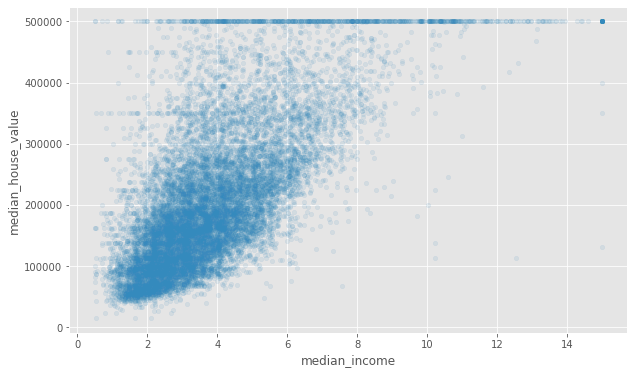

In [17]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(10,6))

In [18]:
# Create new features

housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedroms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedroms_per_room           -0.259952
Name: median_house_value, dtype: float64

In [19]:
# housing = housing.loc[housing["rooms_per_household"] < 10]
# housing.plot(
#   kind="scatter", x="longitude", y="latitude", figsize=(15, 12), 
#   alpha=0.9,
#   c="rooms_per_household",
#   title="Population density / Median house value"
#   )
# plt.legend()
# plt.show()

In [20]:

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

5. Data Cleaning

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [22]:
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [23]:
X = imputer.transform(housing_num)

# .transform() and .fit() can be replaced with .fit_transform()

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


6. Text and categorical values

In [24]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [25]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]  
# This enforces a correlation bettwen close values which is not the case for this feature. For example <1H Ocean (0) is closer to
# Near Ocean (4) than to Inland (1). One hot encoder can fix this by createing a binary column for each category.

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [26]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [27]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # Can be converted to numpy array with .toarray() method

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [28]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

7. Custom transformer

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from numpy import ndarray

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttrributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room: bool = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room

  def fit(self, X: ndarray, y: ndarray=None):
    return self
  
  def transform(self, X: ndarray) -> ndarray:
    rooms_per_household: ndarray = X[:, rooms_ix] / X[:, households_ix]
    population_per_household: ndarray = X[:, population_ix] / X[:, households_ix]

    if not self.add_bedrooms_per_room:
      return np.c_[X, rooms_per_household, population_per_household]
    
    bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
    return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]


In [30]:
attr_adder = CombinedAttrributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

7. Transformation Pipeline

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
  ("imputer", SimpleImputer(strategy="median")),
  ("attribs_adder", CombinedAttrributesAdder()),
  ("std_scaler", StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [32]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
  ("nnum", num_pipeline, num_attribs),
  ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

#### LinearRegression

In [33]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [34]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", list(lin_reg.predict(some_data_prepared)))
print("Labels:" , list(some_labels))

Predictions: [85657.90192014375, 305492.607374877, 152056.46122455705, 186095.70946094397, 244550.67966088967]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [35]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68627.87390018745


#### DecisionTreeRegressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [37]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [38]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [39]:
def display_scores(scores: ndarray):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

In [40]:
display_scores(tree_rmse_scores)

Scores: [72527.9077683  72106.90920768 68469.84699996 72285.44253993
 68132.40349476 77720.31535546 71215.02367829 73834.74241468
 68035.84014558 70417.15962914]
Mean: 71474.55912337686
Standard deviation: 2827.638904239164


#### RandomForestRegressor

In [41]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [42]:
housing_predictions = forest_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

18737.975888678793


In [43]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

KeyboardInterrupt: 

8. Saving and loading a model

In [ ]:
# Saving models
import joblib

joblib.dump(forest_reg, "models/housing/forest_reg_model.joblib")
joblib.dump(tree_reg, "models/housing/tree_reg_model.joblib")
joblib.dump(lin_reg, "models/housing/lin_reg_model.joblib")

['models/housing/lin_reg_model.joblib']

In [ ]:
test_model: RandomForestRegressor = joblib.load("models/housing/forest_reg_model.joblib")
housing_predictions = test_model.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

18715.345974662156


8. Fine tunning model with Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
  {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 5]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 5],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
print(grid_search.best_estimator_) 
print(grid_search.best_params_)

RandomForestRegressor(max_features=6, n_estimators=30)
{'max_features': 6, 'n_estimators': 30}


In [ ]:
cvres = grid_search.cv_results_
for mean_score,params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63962.22776252645 {'max_features': 2, 'n_estimators': 3}
55969.54301500868 {'max_features': 2, 'n_estimators': 10}
52386.358378726865 {'max_features': 2, 'n_estimators': 30}
60024.27460306288 {'max_features': 4, 'n_estimators': 3}
52947.120968902134 {'max_features': 4, 'n_estimators': 10}
50750.833679132375 {'max_features': 4, 'n_estimators': 30}
59064.41060293033 {'max_features': 6, 'n_estimators': 3}
52321.50291044379 {'max_features': 6, 'n_estimators': 10}
50060.12509205309 {'max_features': 6, 'n_estimators': 30}
58397.67779033586 {'max_features': 8, 'n_estimators': 3}
51941.86962220017 {'max_features': 8, 'n_estimators': 10}
50075.06378921577 {'max_features': 8, 'n_estimators': 30}
61467.42137038077 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53986.493766819294 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60684.42175996456 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52503.938278085014 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.34928043e-02, 6.75619728e-02, 4.53577273e-02, 1.73782112e-02,
       1.69604995e-02, 1.79604168e-02, 1.62609063e-02, 3.67827532e-01,
       6.21387841e-02, 1.12257973e-01, 5.52670509e-02, 1.28679786e-02,
       1.25987770e-01, 1.05371248e-04, 3.20944922e-03, 5.36555322e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedroms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attribiutes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attribiutes), reverse=True)

[(0.3678275315247044, 'median_income'),
 (0.12598776963201788, 'NEAR OCEAN'),
 (0.1122579733570433, 'INLAND'),
 (0.07349280426058354, 'longitude'),
 (0.06756197281827829, 'latitude'),
 (0.062138784112395595, '<1H OCEAN'),
 (0.055267050877763894, 'ISLAND'),
 (0.04535772725446998, 'housing_median_age'),
 (0.017960416787772944, 'population'),
 (0.01737821124702706, 'total_rooms'),
 (0.01696049950686031, 'total_bedrooms'),
 (0.016260906303746707, 'households'),
 (0.01286797863170621, 'NEAR BAY')]

In [ ]:
final_model: RandomForestRegressor = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

48387.29844399663

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46444.58361402, 50254.96944917])